In [0]:
import pandas as pd
import re
import numpy as np
import pandas as pd
from pprint import pprint

import nltk
nltk.download('stopwords')

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

%load_ext autotime

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yiyingwang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
import pyspark as ps
# Import Spark SQL related packages
from pyspark.sql import functions as F
from pyspark.sql import SparkSession 
from pyspark.sql.types import FloatType, StringType

time: 212 ms


In [0]:
spark = SparkSession\
        .builder\
        .appName('final')\
        .getOrCreate()

time: 4.66 s


In [0]:
post1 = spark.read.format("csv").option("header", "false").load("posts.csv")

time: 237 ms


In [0]:
post11 = post1.withColumnRenamed("_c0", "Post ID")\
        .withColumnRenamed("_c1", "Title")\
        .withColumnRenamed("_c2", "Author")\
        .withColumnRenamed("_c3", "BloggerID")\
        .withColumnRenamed("_c4", "num_of_comments")\
        .withColumnRenamed("_c5", "content")\
        .withColumnRenamed("_c6", "URL")\

time: 31.3 ms


In [0]:
#post=pd.read_csv("posts.csv",header=None)

In [0]:
#colnames=["ID","title","bloggername","bloggerID","num_of_comment","content","URL","Date","num_of_retrivied_links","num_of_Retrivied_comments","postlength_words","postlength_nonstopwords","average_word_length","average_word_length_nonstop","MEIBI","MEIBIX"]
#post.columns=colnames

In [0]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [0]:
from pyspark.ml.feature import RegexTokenizer

regexTokenizer = RegexTokenizer(gaps=False, pattern='\w+', inputCol='content', outputCol='text_token')

post11 = regexTokenizer.transform(post11)
post11.select('Post ID', 'content', 'text_token').show(3, truncate=True)



+-------+--------------------+--------------------+
|Post ID|             content|          text_token|
+-------+--------------------+--------------------+
|      1|During his keynot...|[during, his, key...|
|      2|Later this month ...|[later, this, mon...|
|      3|A NYTimes communi...|[a, nytimes, comm...|
+-------+--------------------+--------------------+
only showing top 3 rows

time: 126 ms


In [0]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
#print(trigram_mod[bigram_mod[data_words[0]]])

In [0]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

time: 1.42 ms


In [0]:
from pyspark.ml.feature import StopWordsRemover

stopWordsRemover = StopWordsRemover(inputCol="text_token", outputCol = 'text_sw_removed')

RemoveDF = stopWordsRemover.transform(TokenDF)
RemoveDF.select('text_token', 'text_sw_removed').show(3, truncate = True)

+--------------------+--------------------+
|          text_token|     text_sw_removed|
+--------------------+--------------------+
|[during, his, key...|[keynote, sxsw, l...|
|[later, this, mon...|[later, month, fa...|
|[a, nytimes, comm...|[nytimes, communi...|
+--------------------+--------------------+
only showing top 3 rows

time: 258 ms


In [0]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 3), (6, 1), (7, 1), (8, 1), (9, 2), (10, 3), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 4), (31, 1), (32, 5), (33, 2), (34, 1), (35, 1), (36, 1), (37, 3), (38, 1), (39, 1), (40, 2), (41, 1), (42, 1), (43, 1), (44, 1), (45, 2), (46, 1), (47, 2), (48, 1), (49, 2), (50, 1), (51, 1), (52, 1), (53, 1), (54, 2), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 3), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 2), (71, 3), (72, 1), (73, 1), (74, 1), (75, 2), (76, 2), (77, 3), (78, 5), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 2), (85, 1), (86, 1), (87, 2), (88, 1), (89, 8), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 2), (98, 3)]]
time: 4.66 s


In [0]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('able', 1),
  ('allow', 2),
  ('almost', 1),
  ('also', 1),
  ('announce', 1),
  ('anywhere', 3),
  ('appear', 1),
  ('appropriately', 1),
  ('boil', 1),
  ('box', 2),
  ('button', 3),
  ('call', 1),
  ('certainly', 1),
  ('change', 1),
  ('clearly', 1),
  ('click', 1),
  ('clicking', 1),
  ('com', 1),
  ('come', 1),
  ('connect', 2),
  ('count', 1),
  ('currently', 1),
  ('date', 1),
  ('easy', 1),
  ('egg', 1),
  ('eggboile', 1),
  ('enough', 1),
  ('environment', 1),
  ('eye', 1),
  ('fast', 1),
  ('feature', 4),
  ('first', 1),
  ('follow', 5),
  ('give', 2),
  ('glance', 1),
  ('hit', 1),
  ('hovercardafter', 1),
  ('image', 3),
  ('information', 1),
  ('inoauth', 1),
  ('integrate', 2),
  ('last', 1),
  ('late', 1),
  ('launch', 1),
  ('let', 1),
  ('link', 2),
  ('load', 1),
  ('log', 2),
  ('loginconnected', 1),
  ('logout', 2),
  ('look', 1),
  ('may', 1),
  ('meet', 1),
  ('month', 1),
  ('new', 2),
  ('next', 1),
  ('open', 1),
  ('option', 1),
  ('page', 1),
  ('pagetest

time: 24.5 ms


In [0]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

time: 4min 17s


In [0]:
from pyspark.ml.clustering import LDA, LDAModel
from pyspark.mllib.linalg import Vectors
# import tensorflow


# Trains a LDA model.
lda = LDA(k=50, maxIter=100)
model = lda.fit(yelp)

ll = model.logLikelihood(yelp)
lp = model.logPerplexity(yelp)
print("The lower bound on the log likelihood of the entire corpus: " + str(ll))
print("The upper bound bound on perplexity: " + str(lp))

# Describe topics.
topics = model.describeTopics(5)
print("The topics described by their top-weighted terms:")
topics.show(truncate=False)

# Shows the result
transformed = model.transform(yelp)
transformed.show(truncate=False)

In [0]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.295*"video" + 0.071*"content" + 0.066*"youtube" + 0.047*"show" + '
  '0.043*"movie" + 0.041*"tv" + 0.030*"watch" + 0.022*"medium" + '
  '0.021*"television" + 0.020*"player"'),
 (1,
  '0.209*"music" + 0.131*"file" + 0.105*"download" + 0.047*"document" + '
  '0.038*"free" + 0.036*"artist" + 0.029*"play" + 0.028*"player" + '
  '0.028*"itune" + 0.028*"audio"'),
 (2,
  '0.086*"block" + 0.056*"demographic" + 0.053*"chief" + 0.049*"government" + '
  '0.046*"everywhere" + 0.042*"broadband" + 0.034*"officer" + '
  '0.031*"celebrate" + 0.021*"merger" + 0.020*"propose"'),
 (3,
  '0.120*"book" + 0.119*"article" + 0.054*"print" + 0.042*"drm" + '
  '0.039*"reading" + 0.036*"author" + 0.029*"woman" + 0.028*"newspaper" + '
  '0.028*"magazine" + 0.023*"paper"'),
 (4,
  '0.047*"feature" + 0.037*"user" + 0.036*"email" + 0.035*"web" + '
  '0.029*"application" + 0.023*"version" + 0.021*"add" + 0.021*"allow" + '
  '0.017*"tool" + 0.017*"use"'),
 (5,
  '0.116*"service" + 0.031*"free" + 0.029*"offer

In [0]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/Users/yiyingwang/Downloads/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

time: 2min 55s


In [0]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

[(19,
  [('mobile', 0.057321513376602816),
   ('phone', 0.03868133607725186),
   ('device', 0.036346366946335286),
   ('screen', 0.017057147380085482),
   ('computer', 0.013495330061738166),
   ('run', 0.010495488364730094),
   ('android', 0.009426943169225899),
   ('work', 0.008469210068070287),
   ('pc', 0.007179040683868925),
   ('carrier', 0.007107804337501979)]),
 (4,
  [('feature', 0.04442745371676292),
   ('page', 0.031874935047582285),
   ('photo', 0.030286384488620335),
   ('user', 0.028972489867422836),
   ('add', 0.026634202829698472),
   ('browser', 0.020925813204269787),
   ('image', 0.020020190922992412),
   ('version', 0.019025491040277922),
   ('web', 0.017585403150377838),
   ('widget', 0.01643481746514839)]),
 (14,
  [('call', 0.05126454223571067),
   ('email', 0.04325577474287641),
   ('service', 0.03475805091890069),
   ('send', 0.030247850278199293),
   ('user', 0.027145506659922443),
   ('message', 0.026943179902208732),
   ('number', 0.02586410386106896),
   ('ac

In [0]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

time: 1.85 ms


In [0]:
compute_coherence_values_udf=F.udf(compute_coherence_values, StringType())
post11=post11.withColumn("model_list",compute_coherence_values_udf(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6))

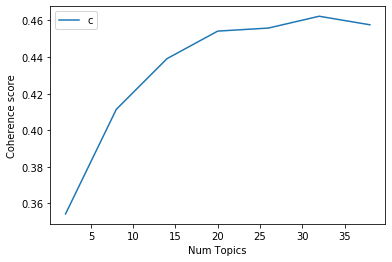

time: 386 ms


In [0]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
# optimal topic number=20

In [0]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.137*"video" + 0.053*"content" + 0.042*"show" + 0.030*"live" + '
  '0.026*"youtube" + 0.023*"watch" + 0.022*"tv" + 0.019*"web" + 0.018*"movie" '
  '+ 0.017*"medium"'),
 (1,
  '0.034*"web" + 0.031*"application" + 0.024*"service" + 0.024*"platform" + '
  '0.021*"software" + 0.018*"customer" + 0.017*"datum" + 0.017*"product" + '
  '0.016*"build" + 0.016*"developer"'),
 (2,
  '0.044*"feature" + 0.035*"page" + 0.027*"add" + 0.027*"user" + '
  '0.024*"version" + 0.021*"web" + 0.018*"file" + 0.017*"widget" + '
  '0.016*"browser" + 0.015*"create"'),
 (3,
  '0.048*"blog" + 0.045*"news" + 0.042*"post" + 0.031*"story" + '
  '0.031*"comment" + 0.025*"write" + 0.022*"reader" + 0.015*"content" + '
  '0.015*"link" + 0.014*"read"'),
 (4,
  '0.017*"issue" + 0.012*"case" + 0.008*"claim" + 0.008*"remove" + '
  '0.007*"state" + 0.007*"change" + 0.006*"clear" + 0.006*"make" + '
  '0.006*"term" + 0.006*"report"'),
 (5,
  '0.075*"app" + 0.057*"mobile" + 0.045*"game" + 0.042*"application" + '
  '0.04

In [0]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus,post=post):
    # Init output
    post['topic']=0
    # Get main topic in each document
    for i,row in enumerate(ldamodel[corpus]):
        row1=row[0]
        row2 = sorted(row1,key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row2):
            if j == 0:  # => dominant topic
                return topic_num
format_topics_sentences_udf=F.udf(format_topics_sentences,StringType())
post11=post11.withColumn("topic",format_topics_sentences_udf(ldamodel=lda_model, corpus=corpus))

/Users/yiyingwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


time: 1min 32s
